#### === Importing Libraries =====

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from tabulate import tabulate
from sklearn.utils import class_weight
from collections import Counter
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
import shap

# Importing functions from other files
from text_processing_cleanup import text_Processing, text_Processing_GloVe
from data_feature_functions import create_indicator_matrix, get_Fraud_Dataset,get_training_testing_data, get_Geolocation_Data, print_class_report_confusion_matrix, get_combined_feature, get_feature_importance, export_predictions
from predict_CNN_1layer import get_cnn_pred_prob, evaluate_cnn
from ensemble_classifier import train_bagging_ensemble, train_boosting_ensemble, perfrom_GridSearch, perfrom_RandomSearch
from word_vector_functions import  load_word2vec, get_sentence_feature_values, read_glove_file, get_sentence_embeddings
from get_classifier_models import get_classifier_predictions_probabilities
from data_visualization import plot_3d, plot_decision_regions, plot_word_shap
from Text_RNN import KerasTextClassifier, prepare_explanation_words

Using TensorFlow backend.
C:\Users\mromanov\AppData\Local\Continuum\anaconda3\envs\ai_fraud\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mromanov\AppData\Local\Continuum\anaconda3\envs\ai_fraud\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mromanov\AppData\Local\Continuum\anaconda3\envs\ai_fraud\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qi

#### ===== Variable Parameters =========

In [2]:
test_size = 38 # out of 100 percent for train-test split
test_percentage = float(test_size / 100.00)
rand_state = 47 # random state of train/test split
embedding_dim  = 200
text_type = "Clean_Nums_2char"

#### ===== Getting Fraud Data and GloVe embeddings =======

In [3]:
fraud_data = get_Fraud_Dataset(recreate_features = False, fraud_type= 'acceptance')


text = fraud_data['Fraud_Text'] # features or inputs into model
labels = fraud_data['Fraud_Label'] # labels

labels_onehot = create_indicator_matrix(fraud_data['Fraud_Label'], check_index = True)

cleaned_text = text.apply(text_Processing, numbers=False)

glove_dict = read_glove_file(data_type = "accept", dimension = embedding_dim,  vocab_size = "4k", glove_type = text_type)

Initial data path: C:\Current_Projects\Fraud_Project_AI\Initial_Datasets 
 Local Fraud Data Path: C:\Current_Projects\Fraud_Project_AI\Initial_Datasets\MasterFraudData_more datav2.xlsx 
 Feature Gen Path: C:\Current_Projects\Fraud_Project_AI\Feature_Generated_Datasets\Fraud_Features_NoLossDate_acceptance.xlsx
Loading features 



####   =====  Splitting training/testing data and getting longest sentence  =====

In [4]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_text, labels, test_size = test_percentage, random_state = rand_state)

max_doc_length = max([len(words.split(",")) for words in cleaned_text]) # 200 otherwise

####   ===== Training RNN text classifier   =====

In [5]:
rnn_text = KerasTextClassifier(
        max_word_input= max_doc_length, word_cnt=4421, word_embedding_dimension=200,
        labels=list(set(y_train)), batch_size=1024, epoch=12, validation_split=0.1)

rnn_text.fit(X_train, y_train, retrain_RNN = False,  model_type = "Glove_NoNumbers_MoreEpochs")

####   =====  Getting output of RNN and evaluating predicitons  =====

In [6]:
encoded_x_train = rnn_text.transform(X_train)
encoded_x_test = rnn_text.transform(X_test)

rnn_pred = rnn_text.predict(X_test)


####   ===== Using shap values to interpret RNN for certain number of explanations   =====

In [7]:
attrib_data = encoded_x_train[100:300]
explainer = shap.DeepExplainer(rnn_text.model, attrib_data)
num_explanations = 20
start = 500
testing_set = encoded_x_test[start: start + num_explanations]
shap_vals = explainer.shap_values(testing_set)

x_test_words = prepare_explanation_words(rnn_text, encoded_x_test, start, num_explanations)


# shap.force_plot(explainer.expected_value[0], shap_vals[0][0], x_test_words[0],  matplotlib=True)



####   =====  Getting shap values for each word  =====

In [8]:
# Getting shap values for accepted words
index_shap_accept = {}
for row, sent in enumerate(testing_set):

    for col, word in enumerate(sent):
        if word > 0:

            if word not in index_shap_accept.keys():
                index_shap_accept[word] = [ shap_vals[1][row][col] ]
            else:
                index_shap_accept[word].append(shap_vals[1][row][col])
                
# Getting shap values for rejected words              
index_shap_reject = {}
for row, sent in enumerate(testing_set):

    for col, word in enumerate(sent):
        if word > 0:

            if word not in index_shap_reject.keys():
                index_shap_reject[word] = [ shap_vals[0][row][col] ]
            else:
                index_shap_reject[word].append(shap_vals[0][row][col])


####   =====  Summing up shap values  =====

In [9]:
word_shap_accept = {}
max_impact = {}
max_fraud = {}

for index, shap_vals in index_shap_accept.items():

    if index in rnn_text.index2word:
        current_word = rnn_text.index2word[index]
        word_shap_accept[current_word] = shap_vals
        max_fraud[current_word] = sum(shap_vals)
        max_impact[current_word] = np.average([abs(elem) for elem in shap_vals])


max_accept = dict([(key,elem) for key, elem in max_fraud.items() if elem > 0])

max_reject = dict([(key, abs(elem)) for key, elem in max_fraud.items() if elem <= 0])


max_accept_50 = dict( list(max_accept.items() )[:50] )

max_reject_50 = dict( list(max_reject.items() )[:50] )

max_impact_50 = dict( list(max_accept.items() )[:50] )

####   =====  Plotting Shap values  =====

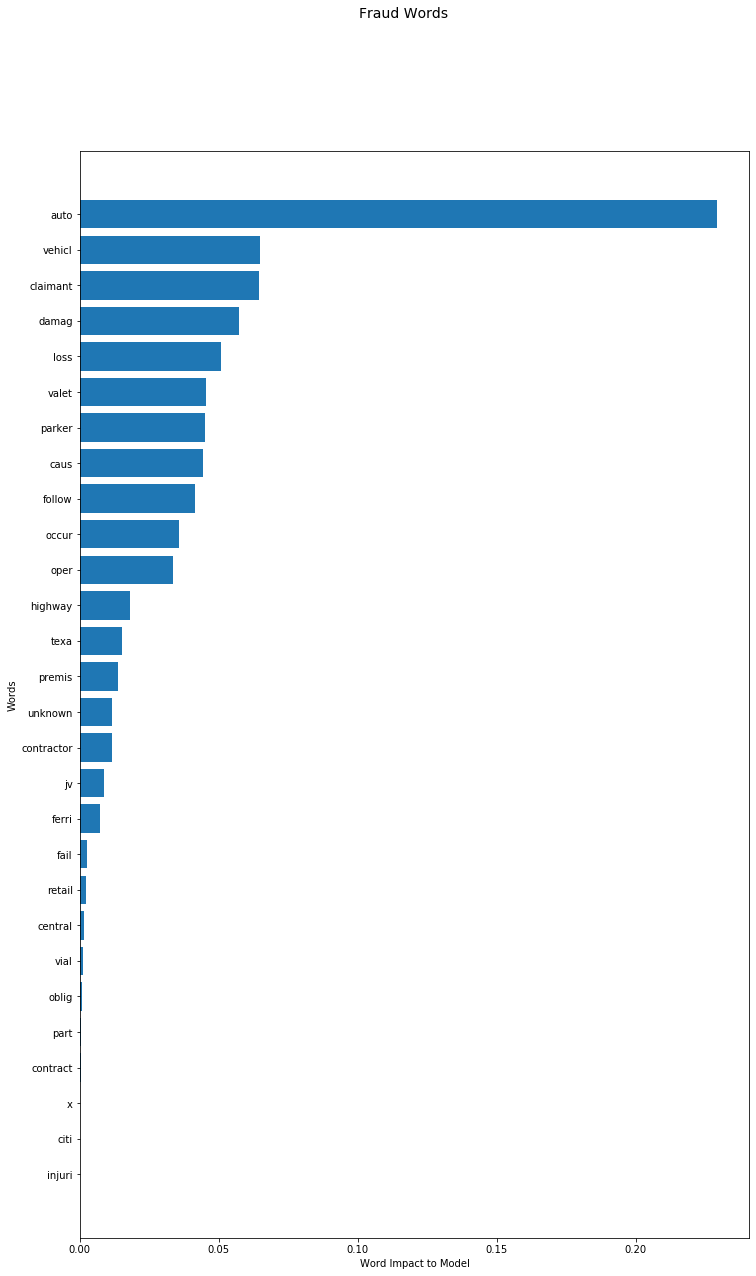

<Figure size 432x288 with 0 Axes>

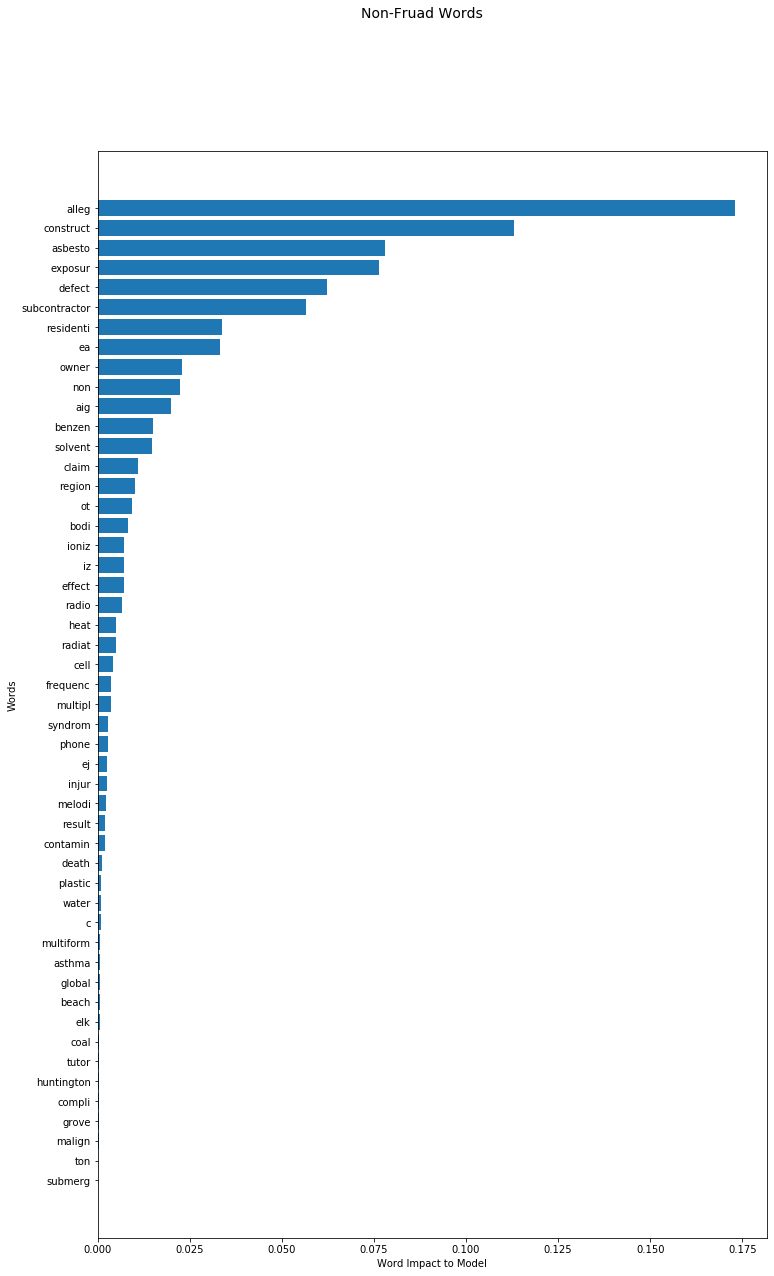

<Figure size 432x288 with 0 Axes>

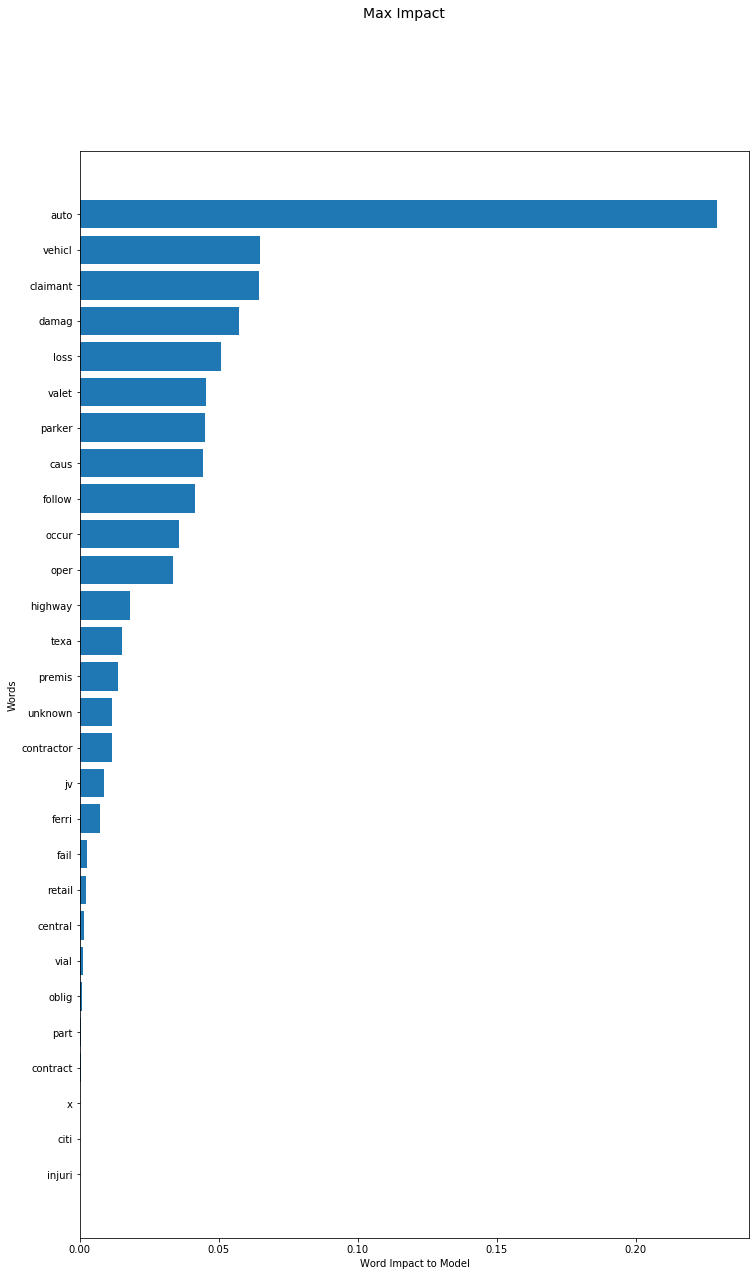

<Figure size 432x288 with 0 Axes>

In [10]:
max_accept_50 = dict( list(max_accept.items() )[:50] )

max_reject_50 = dict( list(max_reject.items() )[:50] )

max_impact_50 = dict( list(max_accept.items() )[:50] )

plot_word_shap(word_shap_dict = word_shap_accept, words_to_plot = max_accept_50, plot_type = 'Fraud Words')

plot_word_shap(word_shap_dict = word_shap_accept,words_to_plot = max_reject_50, plot_type = 'Non-Fruad Words')

plot_word_shap(word_shap_dict = word_shap_accept,words_to_plot = max_impact_50,  plot_type = 'Max Impact')

